In [1]:
import import_ipynb

from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from IPython.display import display, Image, HTML, update_display
from keras.layers import Input, Dense, Lambda, Dropout
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import plot_model
from keras.regularizers import L1L2
from threading import Thread, Lock
from keras.models import Model
import keras_tuner as kt
import tensorflow as tf
import numpy as np
import warnings
import datetime
import dataset
import tools
import users
import time
import uuid
import ads
import os

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [2]:
root_directories = ["ADS16_Benchmark_part1", "ADS16_Benchmark_part2"]

In [3]:
def load_user_and_ad_ftrs(root_directories, try_load_files=True, save_files=True):
    ad_ftrs_path = os.path.join("data", "ad_ftrs.npz")
    user_ftrs_and_ratings_path = os.path.join("data", "user_ftrs_and_ratings.npz")

    if try_load_files and os.path.exists(ad_ftrs_path):
        with np.load(ad_ftrs_path) as ad_ftrs_file:
            ad_ftrs = ad_ftrs_file["ftrs"]
            num_categories = int(ad_ftrs_file["num_categories"])
    else:
        ad_ftrs, num_categories = ads.load_ftrs(root_directories)
        if save_files:
            np.savez(ad_ftrs_path, ftrs=ad_ftrs, num_categories=num_categories)
    
    if try_load_files and os.path.exists(user_ftrs_and_ratings_path):
        with np.load(user_ftrs_and_ratings_path) as user_ftrs_and_ratings:
            user_ftrs = user_ftrs_and_ratings["user_ftrs"]
            ratings = user_ftrs_and_ratings["ratings"]
    else:
        raw_user_ftrs, ratings = users.load_raw_ftrs(root_directories)
        *_, user_ftrs = users.calculate_pca_ftrs(raw_user_ftrs)
        if save_files:
            np.savez(user_ftrs_and_ratings_path, user_ftrs=user_ftrs, ratings=ratings)
    
    return ad_ftrs, num_categories, user_ftrs, ratings

if __name__ == "__main__":
    ad_ftrs, num_categories, user_ftrs, ratings = load_user_and_ad_ftrs(root_directories)

In [4]:
if __name__ == "__main__":
    X = tools.ftr_cartesian_product(user_ftrs, ad_ftrs)
    ratings_normalizer = StandardScaler()
    Y = ratings_normalizer.fit_transform(ratings.flatten()[:, np.newaxis])[:,0]
    
    test_split = 0.2
    test_num = int(test_split * X.shape[0])
    X_train, X_test = X[:-test_num], X[-test_num:]
    Y_train, Y_test = Y[:-test_num], Y[-test_num:]


In [5]:
def plot_distributions(model, title):
    rows = num_categories
    cols = 3

    fig = plt.figure(constrained_layout=True, figsize=(cols*8, rows*6))
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        fig.suptitle(title, fontsize=20)
        fig.patch.set_facecolor("white")
        
        subfigs = fig.subfigures(rows, 1)

        bins = bins=np.arange(1,5+2,1) - 0.5
        bin_centers = 0.5*(bins[1:]+bins[:-1])

        pred = ratings_normalizer.inverse_transform(model.predict(X))

        user_ftr_params = users.approximate_normal_params(user_ftrs.T)
        sim_user_ftrs = users.generate_synthetic_pca_ftrs(user_ftrs.shape[0], user_ftr_params)
        
        sim_pred = ratings_normalizer.inverse_transform(model.predict(tools.ftr_cartesian_product(sim_user_ftrs, ad_ftrs)))

        for cat, subfig in enumerate(subfigs):
            subfig.suptitle(f"Category {cat}", fontsize=16)

            axs = subfig.subplots(1, cols)

            for col, ax in enumerate(axs):
                ax.plot()
                ax.set_xlabel(f"Rating")
                ax.set_ylabel(f"Probability Density")
                ax.xaxis.set_major_locator(MaxNLocator(integer=True))

            cat_mask = ad_ftrs[:,cat] == 1
            real_cat_ratings = ratings[:,cat_mask]
            pred_cat_ratings = pred.reshape(ratings.shape)[:,cat_mask]
            sim_cat_ratings = sim_pred.reshape(ratings.shape)[:,cat_mask]

            i = 0

            axs[i].set_title(f"Ground Truth")
            for user in real_cat_ratings:
                heights, _ = np.histogram(user, bins=bins, density=True)
                axs[i].plot(bin_centers, heights, c="blue", alpha=0.1)
            i += 1
            
            axs[i].set_title(f"Predicted (Real Users)")
            for user in pred_cat_ratings:
                heights, _ = np.histogram(user, bins=bins, density=True)
                axs[i].plot(bin_centers, heights, c="red", alpha=0.1)
            i += 1
            
            axs[i].set_title(f"Predicted (Simulated Users)")
            for user in sim_cat_ratings:
                heights, _ = np.histogram(user, bins=bins, density=True)
                axs[i].plot(bin_centers, heights, c="green", alpha=0.1)
            i += 1
        
        plt.close()
    return fig

# if __name__ == "__main__":
#     display(plot_distributions(create_model(), "Rating Distributions"))


In [6]:
def call_with_args_kwargs(func, args, kwargs):
    return func(*args, **kwargs)

class DisplayableCallback(Callback):
    def __init__(self, name, create_display_immediately=True, **kwargs):
        super().__init__(**kwargs)
        self.name = name
        self.display_id = f"{self.name}-{str(uuid.uuid1())}"
        if create_display_immediately:
            self.create_display()
    
    def create_display(self):
        display(HTML(self.name), display_id=self.display_id)
    
    def update_display(self, obj):
        update_display(obj, display_id=self.display_id)

class Printer(DisplayableCallback):
    def __init__(self, **kwargs):
        super().__init__("Epoch Data", **kwargs)
        
    def on_epoch_end(self, epoch, logs=None):
        header = f"Epoch {epoch}"
        lines = []
        if logs is not None:
            for k, v in logs.items():
                lines.append(f"{k}={v:.5f}")
        self.update_display(HTML(f"<h3>{header}</h3>"+"<br/>".join(lines)))
        return super().on_epoch_end(epoch, logs=logs)
    

class ModelDisplayer(DisplayableCallback):
    def __init__(self, **kwargs):
        super().__init__("Model Topology", **kwargs)
    
    def on_epoch_end(self, epoch, logs=None):
        model_plot_filename = "data/tmp.png"
        plot_model(self.model, to_file=model_plot_filename, show_shapes=True, show_layer_activations=True, show_layer_names=True)
        self.update_display(Image(model_plot_filename))
        os.unlink(model_plot_filename)
        return super().on_epoch_end(epoch, logs=logs)


class DistributionPlotter(DisplayableCallback):
    def __init__(self, **kwargs):
        super().__init__("Rating Distributions", **kwargs)
        self.lock = Lock()
        
    def on_epoch_end_(self, epoch, logs=None):
        with self.lock:
            self.update_display(plot_distributions(self.model, f"Rating Distributions: Epoch {epoch}"))

    def on_epoch_end(self, epoch, logs=None):
        if not self.lock.locked():
            Thread(target=self.on_epoch_end_, args=(epoch, logs)).start()
        return super().on_epoch_end(epoch, logs=logs)
    
    def plot_now(self):
        with self.lock:
            self.update_display(plot_distributions(self.model, f"Rating Distributions"))
            

if __name__ == "__main__":
    logs_dir="user_ad_interaction_model_logs"
    checkpoints_dir = os.path.join(logs_dir, "checkpoints")
    filepath = os.path.join(checkpoints_dir, "model-{epoch:06d}-{val_loss:06f}.hdf5")
    checkpoint = ModelCheckpoint(filepath, monitor=["val_loss"], save_weights_only=True, verbose=0, save_best_only=False, mode="min")

    log_dir = os.path.join(logs_dir, "fit", datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    

In [7]:
def std_dev_pct_error(y_true, y_pred):
    ε = 1e-6
    std_true = tf.math.reduce_std(y_true)
    std_pred = tf.math.reduce_std(y_pred)
    return tf.math.abs((std_pred - std_true)/(std_pred + ε))

def create_model(hp=None):
    ad_ftrs, _, user_ftrs, ratings = load_user_and_ad_ftrs(root_directories)
    ratings_normalizer = StandardScaler()
    ratings_normalizer.fit(ratings.flatten()[:, np.newaxis])

    inputs = Input((user_ftrs.shape[1]+ad_ftrs.shape[1]), name="input")

    input_dropout_rate = 0.5 if hp is None else hp.Choice("input_dropout", values=[0.0, 0.1, 0.3, 0.5])
    output = inputs if input_dropout_rate == 0 else Dropout(input_dropout_rate, name="input_dropout")(inputs)

    l1 = 1e-2 if hp is None else hp.Choice("l1", values=[1e-2, 1e-3, 1e-4])
    l2 = 1e-2 if hp is None else hp.Choice("l2", values=[1e-2, 1e-3, 1e-4])
    reg = L1L2(l1=l1, l2=l2)

    num_hidden_layers = 2 if hp is None else hp.Int("num_hidden_layers", 1, 3)
    for i in range(num_hidden_layers):
        units = 32 if hp is None else hp.Int(f"units_{i}", min_value=2, max_value=16, step=2)
        output = Dense(units, activation="relu", kernel_regularizer=reg, name=f"hidden_{i}")(output)
        dropout_rate = 0.5 if hp is None else hp.Choice(f"dropout_{i}", values=[0.0, 0.1, 0.3, 0.5])
        if dropout_rate != 0:
            output = Dropout(dropout_rate, name=f"hidden_dropout_{i}")(output)

    output = Dense(1, kernel_regularizer=reg, name="raw_output")(output)

    lower_bnd = (1 - ratings_normalizer.mean_) / ratings_normalizer.scale_ 
    upper_bnd = (5 - ratings_normalizer.mean_) / ratings_normalizer.scale_ 

    output = Lambda(lambda x: tf.clip_by_value(x, lower_bnd, upper_bnd), name="clipped_output")(output)

    model = Model(inputs=[inputs], outputs=[output])
    learning_rate = 1e-2 if hp is None else hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=["mae", std_dev_pct_error],
        loss_weights=[1,1],
        metrics=["mae", std_dev_pct_error]
    )

    return model

class MyTuner(kt.Hyperband):
    def run_trial(self, trial, *args, **kwargs):
        kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 32, 256, step=32)
        return super().run_trial(trial, *args, **kwargs)

if __name__ == "__main__":

    tuner = MyTuner(
            create_model,
            objective="val_loss",
            max_epochs=100,
            factor=3,
            hyperband_iterations=5,
            directory=os.path.join(logs_dir, "hypertraining"),
            project_name="user_ad_interaction"
        )
    
    # print("EXAMPLE MODEL --- HYPERPARAMS NOT TUNED")
    # model = create_model()
    # model.summary()
    # c = ModelDisplayer()
    # c.model = model
    # c.on_epoch_end(0)

    # c = DistributionPlotter()
    # c.model = model
    # c.on_train_end()

          

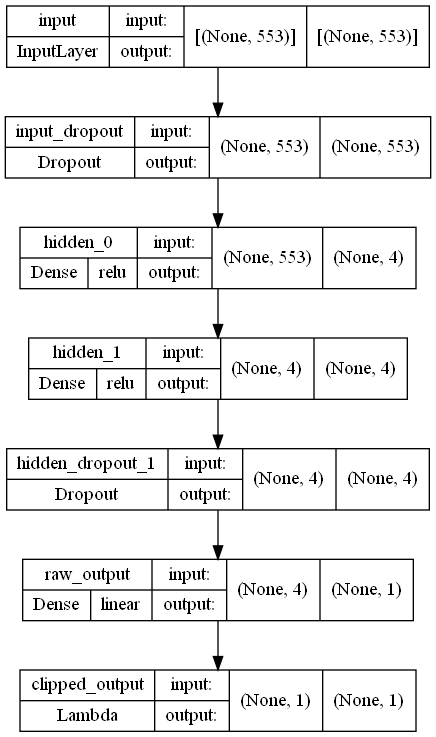

Results summary
Results in user_ad_interaction_model_logs\hypertraining\user_ad_interaction
Showing 1 best trials
Trial summary
Hyperparameters:
input_dropout: 0.1
l1: 0.0001
l2: 0.0001
num_hidden_layers: 1
units_0: 4
dropout_0: 0.3
learning_rate: 0.0001
batch_size: 128
units_1: 2
dropout_1: 0.0
units_2: 10
dropout_2: 0.1
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0749
Score: 0.6781521439552307
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 553)]             0         
                                                                 
 input_dropout (Dropout)     (None, 553)               0         
                                                                 
 hidden_0 (Dense)            (None, 4)                 2216      
                                                                 
 hidden_dr

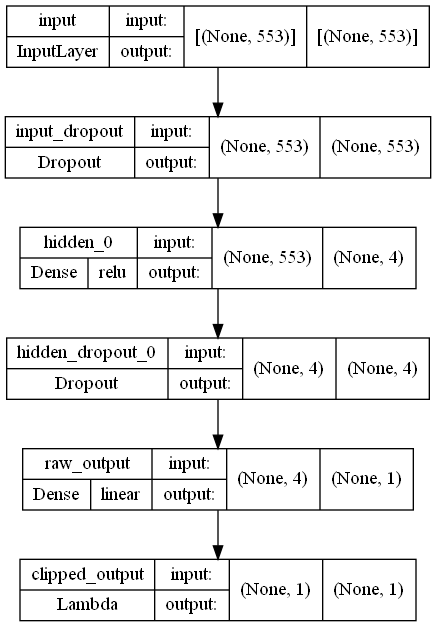

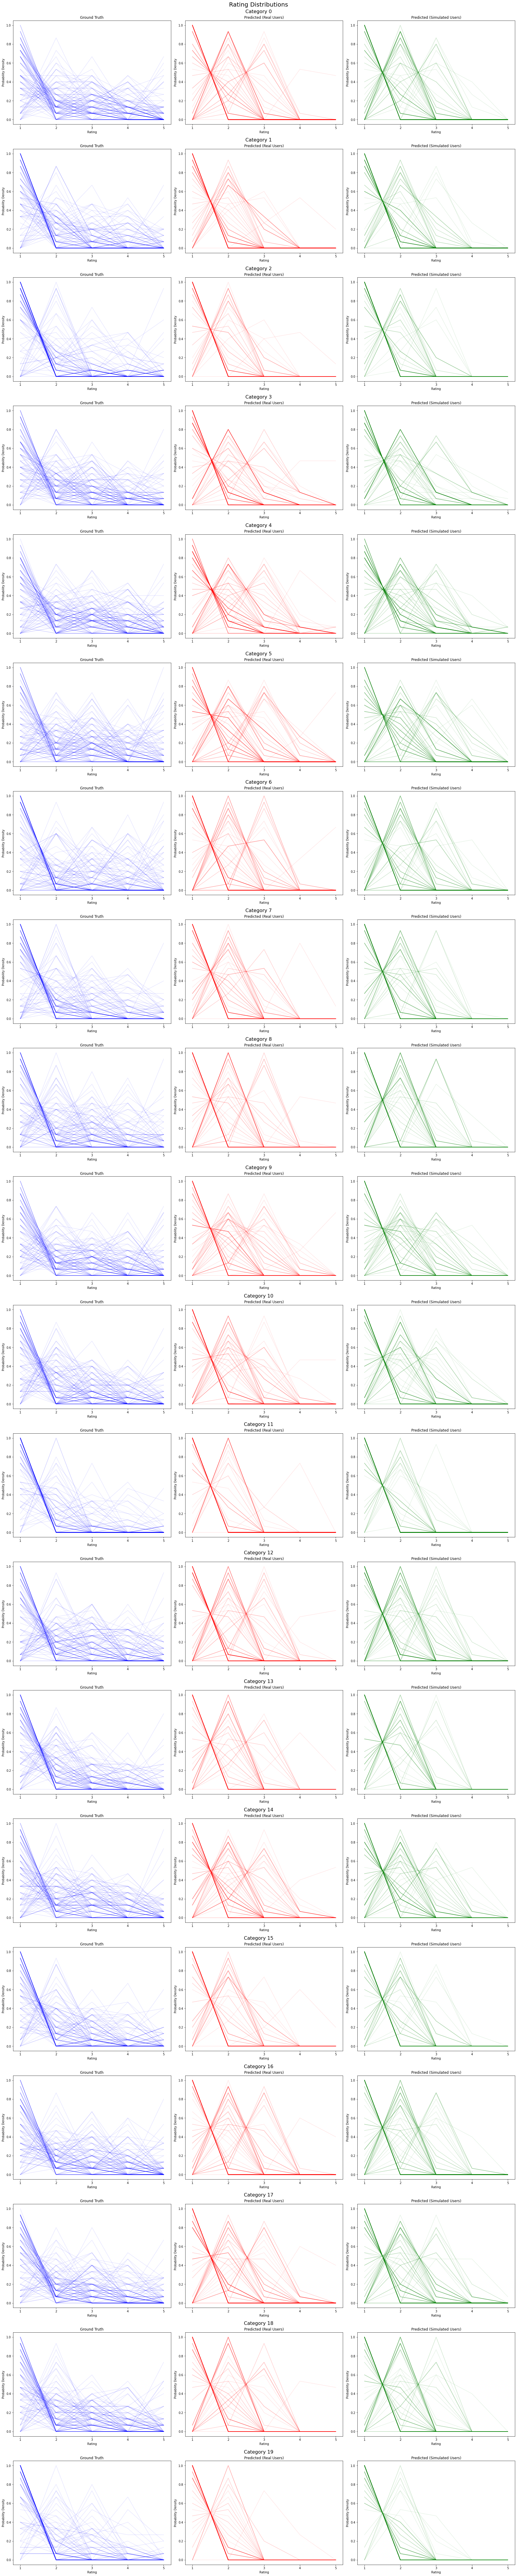

In [8]:
if __name__ == "__main__":
    epochs = 100

    if not os.path.isdir(checkpoints_dir):
        os.makedirs(checkpoints_dir)
    
    
    try:
        tf.get_logger().setLevel("ERROR")

        params = {
            "verbose": 0,
            "shuffle": True,
            "epochs": epochs
        }


        display(HTML("<h2>HyperTuning</h2>"))
        tuner.search(
            X_train,
            Y_train,
            **params,
            validation_split=0.2,
            callbacks=[tensorboard_callback, Printer(), ModelDisplayer(), EarlyStopping(monitor='val_loss', mode="min", patience=5)]
        )


        display(HTML("<h2>Found Optimal Model!</h2>"))
        num_trials = 1

        tuner.results_summary(num_trials=num_trials)
        best_hps=tuner.get_best_hyperparameters(num_trials=num_trials)[0]

        model = tuner.hypermodel.build(best_hps)
        batch_size = best_hps.Int('batch_size', 32, 256, step=32)
        
        # model = create_model()
        # batch_size = 32

        model.summary()

        model.fit(
            X_train,
            Y_train,
            **params,
            batch_size=batch_size,
            validation_data=(X_test,Y_test),
            callbacks=[tensorboard_callback, checkpoint, ModelDisplayer(), Printer(), d:=DistributionPlotter(), EarlyStopping(monitor='val_loss', mode="min", patience=5)]
        )

        d.plot_now()

    except KeyboardInterrupt:
        pass